# Riofreddo
We want to extract the 2m air temperature and the relative humidity over Riofreddo, a village 45 km north-east of Rome, between May 27th and July 5th 2024. The coordinates of the village are: latitude = 42.0615275803612, longitude = 12.999685358882479. We use the [Copernicus ERA5-Land hourly data from 1950 to present](https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-land) as data source. We download the data manually from the Copernicus website (at the time of development the web API did not work). The dataset does not provide directly the relative humidity but it does provide the 2m dew point temperature from which we can calculate the relative humidity.   

In [55]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import cdsapi
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from matplotlib.colors import ListedColormap
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("python version: %s"%python_version())
print("pandas version: %s"%pd.__version__)
print("xarray version: %s"%xr.__version__)
print("matplotlib version: %s"%matplotlib.__version__)
print("cartopy version: %s"%cartopy.__version__)

python version: 3.12.5
pandas version: 2.2.2
xarray version: 2024.7.0
matplotlib version: 3.9.2
cartopy version: 0.23.0


The spatial resolution of the data is 0.1°x0.1° so we select a bounding box around the given point location.

In [5]:
bb_north = 42.20
bb_south = 41.80
bb_west = 12.80
bb_east = 13.10
area = [bb_north, bb_west, bb_south, bb_east]

In [58]:
os.environ['CDSAPI_URL'] = 'https://cds.climate.copernicus.eu/api'
os.environ['CDSAPI_KEY'] = '#####################################'

In order to get the data from May to July we have to send three requests to the C3S service, one for each month. 

In [59]:
def build_request(year, month, days, bbox):
    '''
    This function builds a request for ERA5-Land. It can be 
    used to send several requests enabling the setting of the 
    year, month, days and bounding box. The arguments must be 
    passed as strings or list of strings.
    '''
    request = {
        "variable": [
            "2m_dewpoint_temperature",
            "2m_temperature"
    ],
    "year": year,
    "month": month,
    "day": days,
    "time": [
        "00:00", "01:00", "02:00",
        "03:00", "04:00", "05:00",
        "06:00", "07:00", "08:00",
        "09:00", "10:00", "11:00",
        "12:00", "13:00", "14:00",
        "15:00", "16:00", "17:00",
        "18:00", "19:00", "20:00",
        "21:00", "22:00", "23:00"
    ],
    "data_format": "netcdf",
    "download_format": "zip",
    "area": bbox
    }
    return request

In [60]:
days_may = [str(day) for day in range(27,32)]
request_may = build_request('2024', '05', days_may, area)

In [61]:
days_june = ['0' + str(day) if (day < 10)  else str(day) for day in range(1,31)]
request_june = build_request('2024', '06', days_june, area)

In [62]:
days_july = ['0' + str(day) if (day < 10)  else str(day) for day in range(1, 6)]
request_july = build_request('2024', '07', days_july, area)

In [63]:
DATADIR = 'data/riofreddo'

In [64]:
client = cdsapi.Client()

In [65]:
dataset = "reanalysis-era5-land"

In [68]:
month = 'july'
client.retrieve(dataset, request_july, f'{DATADIR}/download_{month}.zip')

2024-10-09 12:27:52,681 WARNING [2024-10-09T10:27:52.452404] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2024-10-09 12:27:52,682 INFO Request ID is ab91d924-8dfc-49f6-8515-9fed24bfca28
2024-10-09 12:27:52,717 INFO status has been updated to accepted
2024-10-09 12:27:56,562 INFO status has been updated to running
2024-10-09 12:28:42,276 INFO status has been updated to successful


802213ef2531861856dbe0f849353234.zip:   0%|          | 0.00/49.2k [00:00<?, ?B/s]

'data/riofreddo/download_july.zip'

In [69]:
months = ['may', 'june', 'july']

In [72]:
for month in months:
    with ZipFile(f'{DATADIR}/download_{month}.zip', 'r') as zipObj:
       zipObj.extractall(path=f'{DATADIR}/data_{month}')

In [82]:
riofreddo_ds_months = []
for month in months:
    riofreddo_ds_months.append(xr.open_dataset(f'{DATADIR}/data_{month}/data_0.nc'))

In [85]:
riofreddo_ds = xr.merge(riofreddo_ds_months)
riofreddo_ds

<xarray.Dataset> Size: 169kB
Dimensions:     (valid_time: 960, latitude: 5, longitude: 4)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8kB 2024-05-27 ... 2024-07-05T23:...
  * latitude    (latitude) float64 40B 42.2 42.1 42.0 41.9 41.8
  * longitude   (longitude) float64 32B 12.8 12.9 13.0 13.1
    number      int64 8B 0
    expver      (valid_time) object 8kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    d2m         (valid_time, latitude, longitude) float32 77kB 283.0 ... 289.7
    t2m         (valid_time, latitude, longitude) float32 77kB 285.3 ... 293.6
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-09T10:20 GRIB to CDM+CF via cfgrib-0.9.1...

In [86]:
temperature_da = riofreddo_ds['t2m']
dew_point_da = riofreddo_ds['d2m']
lats = riofreddo_ds['latitude']
lons = riofreddo_ds['longitude']

## Time series of the 2m air temperature in Riofreddo

Text(0.5, 1.0, 'ERA5-Land 2 meter air temperature - 2022-06-30T15:00:00')

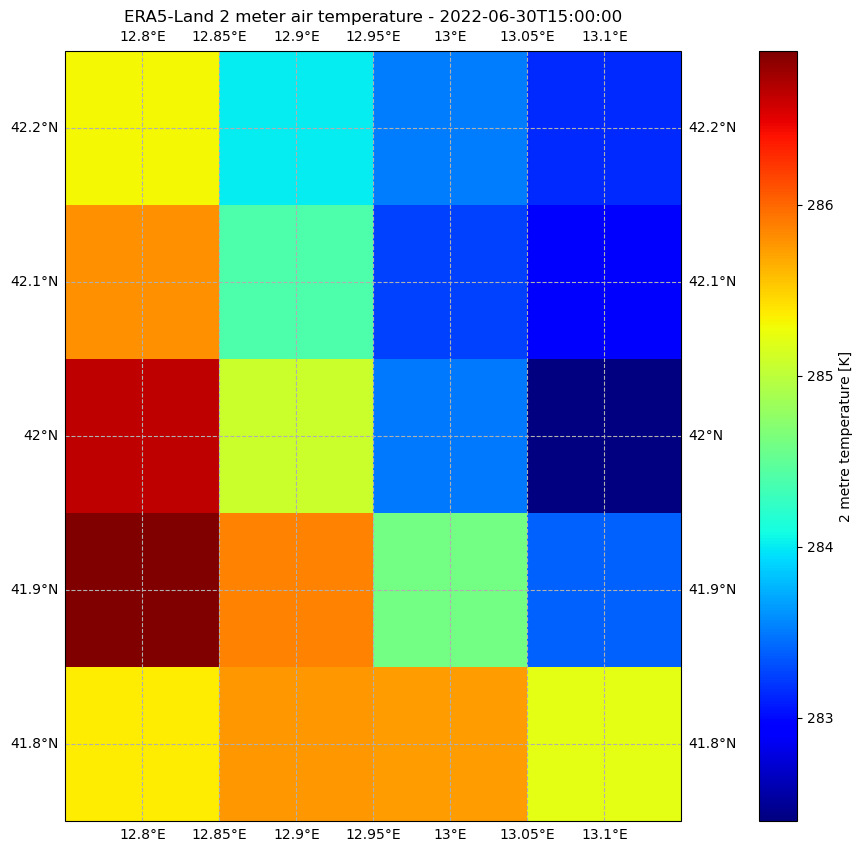

In [87]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linestyle='--')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
temperature_da.sel(valid_time='2024-06-01T00:00:00').plot(ax=ax, add_colorbar=True, cmap='jet')
plt.title('ERA5-Land 2 meter air temperature - 2022-06-30T15:00:00')

In [89]:
riofreddo_temperature_da = temperature_da.sel(latitude = 42.0615275803612, longitude = 12.999685358882479, method='nearest')

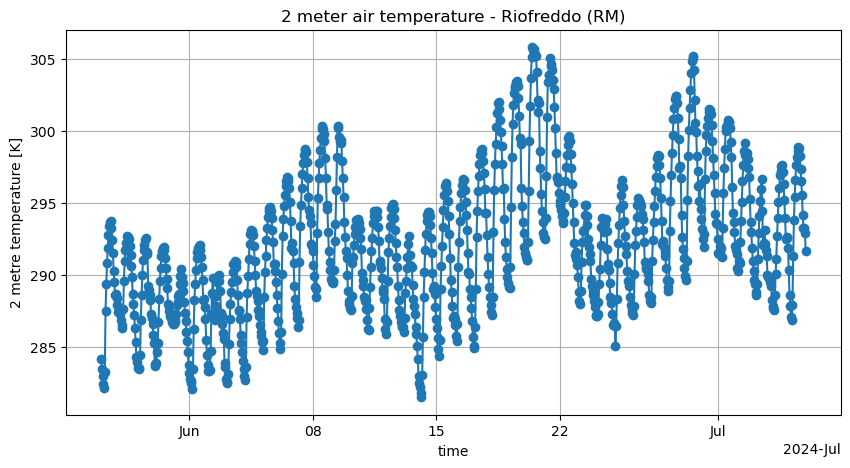

In [118]:
fig, ax = plt.subplots(figsize=(10, 5))
riofreddo_temperature_da.plot(marker='o')
ax.set_title("2 meter air temperature - Riofreddo (RM)")
ax.grid(True)

## Time series of the 2m dew point temperature in Riofreddo

In [94]:
riofreddo_dew_point_da = dew_point_da.sel(latitude = 42.0615275803612, longitude = 12.999685358882479, method='nearest')

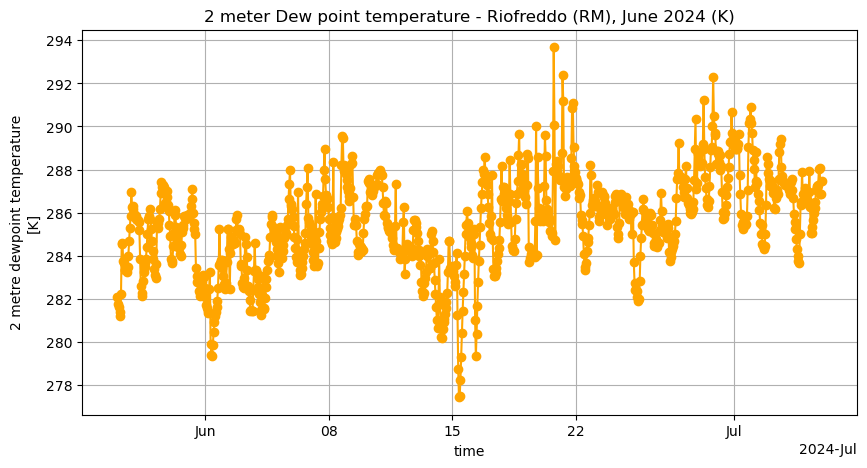

In [120]:
fig, ax = plt.subplots(figsize=(10, 5))
riofreddo_dew_point_da.plot(marker='o', color='orange')
ax.set_title("2 meter Dew point temperature - Riofreddo (RM), June 2024 (K)")
ax.grid(True)

## Transformation from dew point temperature to relative humidity
In order to transform the dew point temperature $T_d$ into relative humidity RH we use the formula

$$RH = \frac{e_s(T_d)}{e_s(T)}$$

where $e_s$ is the water vapor pressure at saturation, in Pa. The water vapor pressure at saturation can be computed from the [Clausius-Clapeyron equation](https://en.wikipedia.org/wiki/Clausius%E2%80%93Clapeyron_relation). To make the calculation easier we can use an approximation such as the August-Roche-Magnus approximation.

$$ e_s(T) = c * exp(\frac{aT}{b + T}) $$

where a, b and c are constants and T is the air temperature in °C. The August-Roche-Magnus approximation is considered valid for:


0 °C < T < 60 °C    
1% < RH < 100%    
0 °C < Td < 50 °C    

In [96]:
a = 17.625
b = 243.04
c = 6.1094

def saturated_water_pressure(T):
    return c * np.exp(a * T / (b + T))

We transform the data from Kelvin to Celsius

In [97]:
riofreddo_dew_point_celsius = riofreddo_dew_point_da - 273.15
riofreddo_temperature_celsius = riofreddo_temperature_da - 273.15

Then we apply the Magnus formula to compute the saturated water vapor pressure 

In [98]:
sat_wvp_dew_point = xr.apply_ufunc(saturated_water_pressure, riofreddo_dew_point_celsius)
sat_wvp_air_temp = xr.apply_ufunc(saturated_water_pressure, riofreddo_temperature_celsius)

Finally we calculate the relative humidity

In [103]:
riofreddo_rh_da = sat_wvp_dew_point / sat_wvp_air_temp   

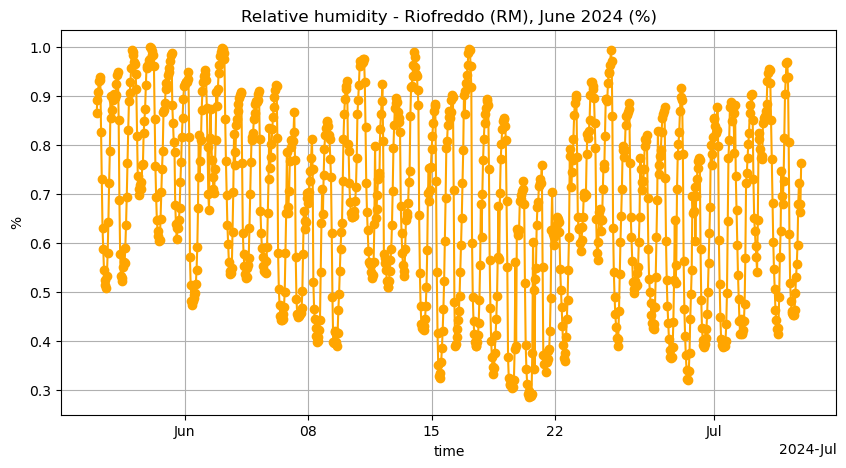

In [123]:
fig, ax = plt.subplots(figsize=(10, 5))
riofreddo_rh_da.plot(marker='o', color='orange')
ax.set_title("Relative humidity - Riofreddo (RM), June 2024 (%)")
ax.set_ylabel('%')
ax.grid(True)

We save the temperature and the relative humidity values into a CSV file.

In [107]:
riofreddo_rh = riofreddo_rh_da.to_series()
riofreddo_temperature = riofreddo_temperature_da.to_series()
riofreddo_df = pd.DataFrame({'Temperature (K)': riofreddo_temperature, 'Relative humidity (%)': riofreddo_rh})
riofreddo_df.head()

,Temperature (K),Relative humidity (%)
valid_time,,
2024-05-27 00:00:00,284.220032,0.866093
2024-05-27 01:00:00,283.488770,0.890966
2024-05-27 02:00:00,283.006348,0.909225
2024-05-27 03:00:00,282.457825,0.929762
2024-05-27 04:00:00,282.155212,0.937995


We save the temperature and the relative humidity time series in a CSV file

In [116]:
riofreddo_df.to_csv('./data/riofreddo/riofreddo_temp_rh_2024.csv')

## References
* [National Physical Laboratory - How do I convert between dew point and relative humidity?](https://www.npl.co.uk/resources/q-a/dew-point-and-relative-humidity)
* [Stull - Practical Meteorology: An Algebra-based Survey of Atmospheric Science](https://www.eoas.ubc.ca/books/Practical_Meteorology/)